In [1]:
"""
GBDT-LR模型
 1.准备GBDT输入的label encoding
 2.准备GBDT输入的 one-hot encoding
 3.建立GBDT-LR模型，并训练调参
 4.预测结果    
    
"""

##==================== 导入工具包 ====================##
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier  # using SGDClassifier for training incrementally
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder  # for one-hot encoding on a large scale of chunks
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pickle
import gc



In [2]:
##==================== 文件路径 ====================##

fp_train_f = "feature_engineering/train_f.csv"
fp_test_f  = "feature_engineering/test_f.csv"
## 子训练集
fp_sub_train_f = "feature_engineering/sub_train_f.csv"

## label encoder for gbdt input
## one-hot encoder for gbdt output
fp_lb_enc = "feature_engineering/lb_enc"
fp_oh_enc_gbdt = "gbdt/oh_enc_gbdt"

## 预训练模型的存储
fp_lr_model = "lr/lr_model"
fp_gbdt_model = "gbdt/gbdt_model"

## 提交的数据
fp_sub_gbdt = "gbdt/GBDT_submission.csv"
fp_sub_gbdt_lr = "gbdt-lr/GBDT-LR_submission.csv"



In [3]:
##==================== GBDT-LR 模型 ====================##
## feature names
cols = ['C1',
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        #'C15',
        #'C16',
        'date',
        'time_period',
        'weekday',
        'C15_C16'  ]

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)


In [4]:
#----- data for GBDT (label encoding) -----#
df_train = pd.read_csv(fp_sub_train_f)  # data load


## label 编码的转换
label_enc = pickle.load(open(fp_lb_enc, 'rb'))
for col in cols:
    df_train[col] = label_enc[col].fit_transform(df_train[col].values)

## 为GBDT 和LR 模型训练分别分割数据
## 这为了防止过拟合
X_train_org = df_train[cols].get_values()
y_train_org = df_train['click'].get_values()

# 30% 做验证集，70%做训练集
X_train, X_valid, y_train, y_valid = train_test_split(X_train_org, y_train_org, test_size = 0.3, random_state = 0)
# gbdt 和 lr 各 50%
X_train_gbdt, X_train_lr, y_train_gbdt, y_train_lr = train_test_split(X_train, y_train, test_size = 0.5, random_state = 0)

del df_train
del X_train
del y_train
gc.collect()


14

In [5]:
#----- GBDT 模型训练-----#
#----- 参数-----#

param = {  # init the hyperparams of GBDT
    'learning_rate': 0.2,
    'n_estimators': 100,  # number of trees here
    'max_depth': 8,  # set max_depth of a tree
    'min_samples_split': 20, 
    'min_samples_leaf': 10,
    'subsample': 0.01, 
    'max_leaf_nodes': None,  # set max leaf nodes of a tree
    'random_state': 1,
    'verbose': 0
    }

gbdt_model = GradientBoostingClassifier()
gbdt_model.set_params(**param)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=20,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=0.01, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [6]:
#----- GBDT 调参 -----#

### 1. n_estimators

log_loss_train = []
log_loss_valid = []
n_estimators = [10,20,30,40,50,60,70,80,90,100,120,140]
for nt in n_estimators:
    print('training: n_estimators = ', nt)
    
    param['n_estimators'] = nt
    gbdt_model.set_params(**param)
    gbdt_model.fit(X_train_gbdt, y_train_gbdt)
    # scores
    y_pred_gbdt = gbdt_model.predict_proba(X_train_gbdt)[:, 1]
    log_loss_gbdt = log_loss(y_train_gbdt, y_pred_gbdt)
    print('log loss of GBDT on train set: %.5f' % log_loss_gbdt)
    log_loss_train.append(log_loss_gbdt)
    
    y_pred_gbdt = gbdt_model.predict_proba(X_valid)[:, 1]
    log_loss_gbdt = log_loss(y_valid, y_pred_gbdt)
    print('log loss of GBDT on valid set: %.5f' % log_loss_gbdt)
    log_loss_valid.append(log_loss_gbdt)
    


training: n_estimators =  10
log loss of GBDT on train set: 0.41883
log loss of GBDT on valid set: 0.41898
training: n_estimators =  20
log loss of GBDT on train set: 0.41525
log loss of GBDT on valid set: 0.41567
training: n_estimators =  30
log loss of GBDT on train set: 0.41400
log loss of GBDT on valid set: 0.41455
training: n_estimators =  40
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: n_estimators =  50
log loss of GBDT on train set: 0.41366
log loss of GBDT on valid set: 0.41443
training: n_estimators =  60
log loss of GBDT on train set: 0.41362
log loss of GBDT on valid set: 0.41439
training: n_estimators =  70
log loss of GBDT on train set: 0.41374
log loss of GBDT on valid set: 0.41453
training: n_estimators =  80
log loss of GBDT on train set: 0.41399
log loss of GBDT on valid set: 0.41490
training: n_estimators =  90
log loss of GBDT on train set: 0.41415
log loss of GBDT on valid set: 0.41519
training: n_estimators =  100
log los

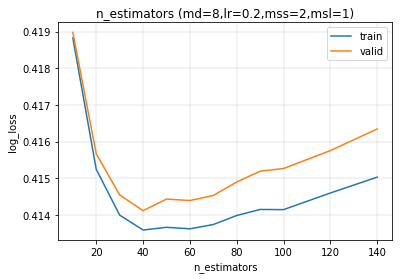

In [7]:
## plot the curve
f1 = plt.figure(1)
plt.plot(n_estimators, log_loss_train, label='train')
plt.plot(n_estimators, log_loss_valid, label='valid')
plt.xlabel('n_estimators')
plt.ylabel('log_loss')
plt.title('n_estimators (md=8,lr=0.2,mss=2,msl=1)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


##### 最佳 n_estimators = 30

In [8]:
param['n_estimators'] = 40

In [9]:
### max_depth
log_loss_train = []
log_loss_valid = []
max_depths = [4,5,6,7,8,9,10,11,12]
for md in max_depths:
    print('training: max_depth = ', md)
    
    param['max_depth'] = md
    gbdt_model.set_params(**param)
    gbdt_model.fit(X_train_gbdt, y_train_gbdt)
    # scores
    y_pred_gbdt = gbdt_model.predict_proba(X_train_gbdt)[:, 1]
    log_loss_gbdt = log_loss(y_train_gbdt, y_pred_gbdt)
    print('log loss of GBDT on train set: %.5f' % log_loss_gbdt)
    log_loss_train.append(log_loss_gbdt)
    
    y_pred_gbdt = gbdt_model.predict_proba(X_valid)[:, 1]
    log_loss_gbdt = log_loss(y_valid, y_pred_gbdt)
    print('log loss of GBDT on valid set: %.5f' % log_loss_gbdt)
    log_loss_valid.append(log_loss_gbdt)
    


training: max_depth =  4
log loss of GBDT on train set: 0.41881
log loss of GBDT on valid set: 0.41895
training: max_depth =  5
log loss of GBDT on train set: 0.41630
log loss of GBDT on valid set: 0.41661
training: max_depth =  6
log loss of GBDT on train set: 0.41496
log loss of GBDT on valid set: 0.41542
training: max_depth =  7
log loss of GBDT on train set: 0.41410
log loss of GBDT on valid set: 0.41476
training: max_depth =  8
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: max_depth =  9
log loss of GBDT on train set: 0.41419
log loss of GBDT on valid set: 0.41491
training: max_depth =  10
log loss of GBDT on train set: 0.41433
log loss of GBDT on valid set: 0.41530
training: max_depth =  11
log loss of GBDT on train set: 0.41458
log loss of GBDT on valid set: 0.41562
training: max_depth =  12
log loss of GBDT on train set: 0.41463
log loss of GBDT on valid set: 0.41606


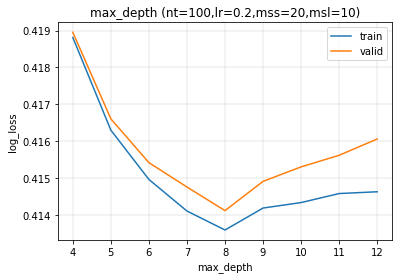

In [10]:
## plot the curve
f1 = plt.figure(2)
plt.plot(max_depths, log_loss_train, label='train')
plt.plot(max_depths, log_loss_valid, label='valid')
plt.xlabel('max_depth')
plt.ylabel('log_loss')
plt.title('max_depth (nt=100,lr=0.2,mss=20,msl=10)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

In [11]:
# 可以得到最佳 max_depth = 8
param['max_depth'] = 8

In [12]:
### min_samples_split
log_loss_train = []
log_loss_valid = []
min_samples_splits = [2,5,10,15,20,25,30,35,40,50,60,70,80]
for mss in min_samples_splits:
    print('training: min_samples_split = ', mss)
    
    param['min_samples_split'] = mss
    gbdt_model.set_params(**param)
    gbdt_model.fit(X_train_gbdt, y_train_gbdt)
    # scores
    y_pred_gbdt = gbdt_model.predict_proba(X_train_gbdt)[:, 1]
    log_loss_gbdt = log_loss(y_train_gbdt, y_pred_gbdt)
    print('log loss of GBDT on train set: %.5f' % log_loss_gbdt)
    log_loss_train.append(log_loss_gbdt)
    
    y_pred_gbdt = gbdt_model.predict_proba(X_valid)[:, 1]
    log_loss_gbdt = log_loss(y_valid, y_pred_gbdt)
    print('log loss of GBDT on valid set: %.5f' % log_loss_gbdt)
    log_loss_valid.append(log_loss_gbdt)
    

training: min_samples_split =  2
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: min_samples_split =  5
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: min_samples_split =  10
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: min_samples_split =  15
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: min_samples_split =  20
log loss of GBDT on train set: 0.41359
log loss of GBDT on valid set: 0.41412
training: min_samples_split =  25
log loss of GBDT on train set: 0.41396
log loss of GBDT on valid set: 0.41454
training: min_samples_split =  30
log loss of GBDT on train set: 0.41375
log loss of GBDT on valid set: 0.41443
training: min_samples_split =  35
log loss of GBDT on train set: 0.41352
log loss of GBDT on valid set: 0.41432
training: min_samples_split =  40
log loss of GBDT on train set: 0.41362
log loss of GBDT on valid set: 0.

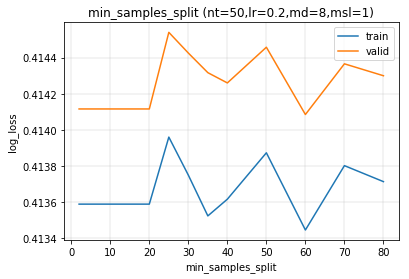

In [13]:
## plot the curve
f1 = plt.figure(3)
plt.plot(min_samples_splits, log_loss_train, label='train')
plt.plot(min_samples_splits, log_loss_valid, label='valid')
plt.xlabel('min_samples_split')
plt.ylabel('log_loss')
plt.title('min_samples_split (nt=50,lr=0.2,md=8,msl=1)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


In [14]:
# 可得最佳的 min_samples_split = 60
param['min_samples_split'] = 60

In [15]:
### min_samples_leaf
log_loss_train = []
log_loss_valid = []
min_samples_leafs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,20,23,26,30]
for msl in min_samples_leafs:
    print('training: min_samples_leaf = ', msl)
    
    param['min_samples_leaf'] = msl
    gbdt_model.set_params(**param)
    gbdt_model.fit(X_train_gbdt, y_train_gbdt)
    # scores
    y_pred_gbdt = gbdt_model.predict_proba(X_train_gbdt)[:, 1]
    log_loss_gbdt = log_loss(y_train_gbdt, y_pred_gbdt)
    print('log loss of GBDT on train set: %.5f' % log_loss_gbdt)
    log_loss_train.append(log_loss_gbdt)
    
    y_pred_gbdt = gbdt_model.predict_proba(X_valid)[:, 1]
    log_loss_gbdt = log_loss(y_valid, y_pred_gbdt)
    print('log loss of GBDT on valid set: %.5f' % log_loss_gbdt)
    log_loss_valid.append(log_loss_gbdt)
    


training: min_samples_leaf =  1
log loss of GBDT on train set: 0.41533
log loss of GBDT on valid set: 0.41596
training: min_samples_leaf =  2
log loss of GBDT on train set: 0.41434
log loss of GBDT on valid set: 0.41529
training: min_samples_leaf =  3
log loss of GBDT on train set: 0.41372
log loss of GBDT on valid set: 0.41436
training: min_samples_leaf =  4
log loss of GBDT on train set: 0.41411
log loss of GBDT on valid set: 0.41470
training: min_samples_leaf =  5
log loss of GBDT on train set: 0.41424
log loss of GBDT on valid set: 0.41474
training: min_samples_leaf =  6
log loss of GBDT on train set: 0.41381
log loss of GBDT on valid set: 0.41441
training: min_samples_leaf =  7
log loss of GBDT on train set: 0.41403
log loss of GBDT on valid set: 0.41462
training: min_samples_leaf =  8
log loss of GBDT on train set: 0.41352
log loss of GBDT on valid set: 0.41406
training: min_samples_leaf =  9
log loss of GBDT on train set: 0.41369
log loss of GBDT on valid set: 0.41431
training: 

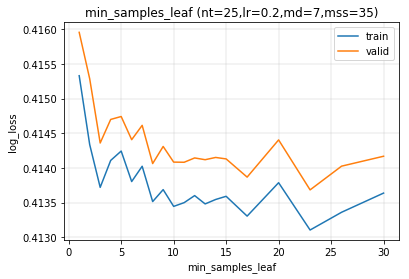

In [16]:
## plot the curve
f1 = plt.figure(4)
plt.plot(min_samples_leafs, log_loss_train, label='train')
plt.plot(min_samples_leafs, log_loss_valid, label='valid')
plt.xlabel('min_samples_leaf')
plt.ylabel('log_loss')
plt.title('min_samples_leaf (nt=25,lr=0.2,md=7,mss=35)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


In [17]:
# 得到最佳的min_samples_leaf = 26
param['min_samples_leaf'] = 26

In [18]:
## fitting
gbdt_model.fit(X_train_gbdt, y_train_gbdt)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=60,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=0.01, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [19]:
## log-loss of training
y_pred_gbdt = gbdt_model.predict_proba(X_train_gbdt)[:, 1]
log_loss_gbdt = log_loss(y_train_gbdt, y_pred_gbdt)
print('log loss of GBDT on train set: %.5f' % log_loss_gbdt)

y_pred_gbdt = gbdt_model.predict_proba(X_valid)[:, 1]
log_loss_gbdt = log_loss(y_valid, y_pred_gbdt)
print('log loss of GBDT on valid set: %.5f' % log_loss_gbdt)

log loss of GBDT on train set: 0.41364
log loss of GBDT on valid set: 0.41417


In [20]:
## store the pre-trained gbdt_model
pickle.dump(gbdt_model, open(fp_gbdt_model, 'wb'))

del X_train_gbdt
del y_train_gbdt
gc.collect()

gbdt_model = pickle.load(open(fp_gbdt_model, 'rb'))


In [21]:
#----- 为 LR 准备数据  -----#
id_cols = []
for i in range(1, gbdt_model.get_params()['n_estimators']+1):
    id_cols.append('tree'+str(i))
oh_enc = OneHotEncoder(id_cols)

def chunker(seq, size):
    return (seq[pos: pos + size] for pos in range(0, len(seq), size))



In [22]:
## oh_enc fit the train_set
df_train_id = pd.DataFrame(gbdt_model.apply(X_train_org)[:, :, 0], columns=id_cols, dtype=np.int8)

for chunk in chunker(df_train_id, 50000):
    oh_enc.fit(chunk)
    
del df_train_id

del X_train_org
del y_train_org
gc.collect()



0

In [23]:
## oh_enc 在测试集上训练
df_test_f = pd.read_csv(fp_test_f, 
                        index_col=None,  dtype={'id':str}, 
                        chunksize=50000, iterator=True)

for chunk in df_test_f:
    ## label transform for training set
    for col in cols:
        chunk[col] = label_enc[col].fit_transform(chunk[col].values)       
    X_test = chunk[cols].get_values()
    
    #----- GBDT-LR 模型 -----#
    df_X_test_id = pd.DataFrame(gbdt_model.apply(X_test)[:, :, 0], columns=id_cols, dtype=np.int8)  # gbdt
    oh_enc.fit(df_X_test_id)


In [24]:
## 存储编码数据
pickle.dump(oh_enc, open(fp_oh_enc_gbdt, 'wb'))

oh_enc = pickle.load(open(fp_oh_enc_gbdt, 'rb'))


In [25]:
#---- LR 模型 -----#
lr_model = SGDClassifier(loss='log')  # using log-loss for LogisticRegression

## input data (one-hot encoding)
df_X_train_lr_id = pd.DataFrame(gbdt_model.apply(X_train_lr)[:, :, 0], columns=id_cols, dtype=np.int8)
df_X_train_lr_id['click'] = y_train_lr


In [30]:
## fitting
for chunk in chunker(df_X_train_lr_id,100000):
    X_train = oh_enc.transform(chunk[id_cols])
    y_train = chunk['click'].astype('int')
    lr_model.partial_fit(X_train, y_train, classes = [0,1]) 

In [36]:
## log-loss of training
log_loss_lr = []
for chunk in chunker(df_X_train_lr_id,1750000):
    X_train_id = oh_enc.transform(chunk[id_cols])
    y_pred_lr = lr_model.predict_proba(X_train_id)[:, 1]
    log_loss_lr_tmp = log_loss(y_train_lr, y_pred_lr)
    print('log loss of LR on train set: %.5f' % log_loss_lr_tmp)
    log_loss_lr.append(log_loss_lr_tmp)

del df_X_train_lr_id
gc.collect()


MemoryError: 

In [28]:
## log-loss of valid
log_loss_lr = []
df_X_valid_id = pd.DataFrame(gbdt_model.apply(X_valid)[:, :, 0], columns=id_cols, dtype=np.int8)
#df_X_valid_id['click'] = y_valid

for chunk in chunker(df_X_valid_id,1750000):
    X_valid_id = oh_enc.transform(chunk[id_cols])
    y_pred_lr = lr_model.predict_proba(X_valid_id)[:, 1]
    log_loss_lr_tmp = log_loss(y_valid, y_pred_lr)
    print('log loss of LR on train set: %.5f' % log_loss_lr_tmp)
    log_loss_lr.append(log_loss_lr_tmp)
    
X2_valid = oh_enc.transform(pd.DataFrame(gbdt_model.apply(X_valid)[:, :, 0], columns=id_cols, dtype=np.int8))
y_pred_lr = lr_model.predict_proba(X2_valid)[:, 1]
log_loss_lr = log_loss(y_valid, y_pred_lr)
print('log loss of LR on valid set: %.5f' % log_loss_lr)



log loss of LR on train set: 0.41401
log loss of LR on valid set: 0.41401


In [29]:
## 保存预训练模型
pickle.dump(lr_model, open(fp_lr_model, 'wb'))

lr_model = pickle.load(open(fp_lr_model, 'rb'))


In [31]:
##==================== 预测 ====================##
df_test_f = pd.read_csv(fp_test_f, 
                        index_col=None,  dtype={'id':str}, 
                        chunksize=1000, iterator=True)        

hd = True
for chunk in df_test_f:
    ## label transform for training set
    for col in cols:
        chunk[col] = label_enc[col].fit_transform(chunk[col].values)       
    X_test = chunk[cols].get_values()
    
    #----- GBDT-LR -----#
    y_pred_gbdt = gbdt_model.predict_proba(X_test)[:, 1]
    X_test_gbdt = pd.DataFrame(gbdt_model.apply(X_test)[:, :, 0], columns=id_cols, dtype=np.int8)
    X2_test = oh_enc.transform(X_test_gbdt)  # one-hot
    y_pred_lr = lr_model.predict_proba(X2_test)[:, 1]  # lr   
    
    #----- 生成submission -----#
    chunk['click_gbdt'] = y_pred_gbdt
    chunk['click_lr'] = y_pred_lr
    with open(fp_sub_gbdt, 'a') as f: 
        chunk.to_csv(f, columns=['id', 'click_gbdt'], header=hd, index=False)
    with open(fp_sub_gbdt_lr, 'a') as f: 
        chunk.to_csv(f, columns=['id', 'click_lr'], header=hd, index=False)
    hd = False
    